# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

### CLStoken mseloss deberta 5folds
### この回からheadはもとのやつに変更

In [1]:
! nvidia-smi

Mon May 16 02:55:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Directory settings

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os
import sys
import json
# INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
# OUTPUT_DIR = './'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)

# CFG

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True

    name = "exp009" # 実験のたびにコピーしてここの名前を変えて実行するとoutputが別のファイルに保存される
    api_path = "/content/drive/MyDrive/kaggle/kaggle.json"
    drive_path = "/content/drive/MyDrive/kaggle/PPPM"
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [4]:
COLAB = "google.colab" in sys.modules

In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 7.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=ab59b95aa7f84cb99b5db9bf15ad45643ce4a7885cbafd065aaafdeef466e14e
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [6]:
if COLAB:
    print("This environment is Google Colab")
    
    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive') 
	
    
    # use kaggle api (need kaggle token)
    f = open(CFG.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # set dirs
    DRIVE = CFG.drive_path
    EXP = CFG.name
    INPUT_DIR = os.path.join(DRIVE, "Input")
    OUTPUT_DIR = os.path.join(DRIVE, "Output")
    SCRIPT = os.path.join(DRIVE, "Script")
    OUTPUT_DIR = os.path.join(OUTPUT_DIR, EXP) 
    # EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    # EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    # EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT_DIR, SCRIPT, OUTPUT_DIR]:
        os.makedirs(d, exist_ok=True)

    if not os.path.isfile(os.path.join(INPUT_DIR, "us-patent-phrase-to-phrase-matching.zip")):
        # load dataset
        ! kaggle competitions download -c us-patent-phrase-to-phrase-matching -p $INPUT_DIR 
        unzip_file = os.path.join(INPUT_DIR, 'us-patent-phrase-to-phrase-matching.zip')
        ! unzip $unzip_file -d $INPUT_DIR
    
    if not os.path.isfile(os.path.join(INPUT_DIR, "cpc-data.zip")):
        # load dataset
        ! kaggle datasets download -d yasufuminakama/cpc-data -p $INPUT_DIR
        unzip_file = os.path.join(INPUT_DIR, 'cpc-data.zip')
        ! unzip $unzip_file -d $INPUT_DIR

else:
    print("This environment is Kaggle Kernel")
    
    # set dirs
    INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
    OUTPUT_DIR = './'
    
    
    # # copy dirs
    # if Config.kaggle_dataset_path is not None:
    #     KD_MODEL = os.path.join(Config.kaggle_dataset_path, "model")
    #     KD_EXP_PREDS = os.path.join(Config.kaggle_dataset_path, "preds")
    #     shutil.copytree(KD_MODEL, EXP_MODEL)
    #     shutil.copytree(KD_EXP_PREDS, EXP_PREDS)

    # # make dirs
    # for d in [EXP_MODEL, EXP_FIG, EXP_PREDS]:
    #     os.makedirs(d, exist_ok=True)
        
    

This environment is Google Colab
Mounted at /content/drive


In [7]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
# !pip install transformers==4.18.0
!pip install transformers[sentencepiece]
!pip install tokenizers==0.12.1
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

import lightgbm as lgb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
     |████████████████████████████████| 4.2 MB 30.6 MB/s 
     |████████████████████████████████| 6.6 MB 57.1 MB/s 
     |████████████████████████████████| 596 kB 56.5 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
     |████████████████████████████████| 1.2 MB 57.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
tokenizers.__version__: 0.12.1
transformers.__version__: 4.19.1
env: TOKENIZERS_PARALLELISM=true


# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'/train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [10]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'/train.csv')
test = pd.read_csv(INPUT_DIR+'/test.csv')
submission = pd.read_csv(INPUT_DIR+'/sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [11]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    if COLAB:
        cpcpath = os.path.join(INPUT_DIR, 'CPCSchemeXML202105')
    else:
        cpcpath = '../input/cpc-data/CPCSchemeXML202105'
    for file_name in os.listdir(cpcpath):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        if COLAB:
            cpcpath = os.path.join(INPUT_DIR, f'CPCTitleList202202/cpc-section-{cpc}_20220201.txt')
        else:
            cpcpath = f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt'
        with open(cpcpath) as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"/cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [12]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

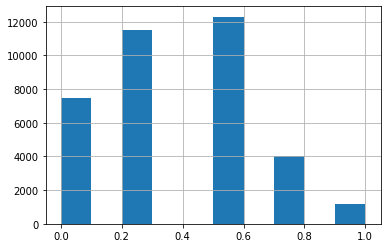

In [13]:
train['score'].hist()

In [14]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [15]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    7295
1    7295
2    7295
3    7294
4    7294
dtype: int64

In [16]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [17]:
# ====================================================
# tokenizer
# ====================================================
! pip install sentencepiece
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'/tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [18]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [19]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [20]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [21]:
class TransformerHead(nn.Module):
    def __init__(self, in_features, max_length, num_layers=1, nhead=8, num_targets=1):
        super().__init__()
        # in_features は各トークンに対するベクトルの次元数
        # max_length は最大トークン数
        self.transformer = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=in_features,
                                                                                          nhead=nhead),
                                                 num_layers=num_layers)
        self.row_fc = nn.Linear(in_features, 1)
        self.out_features = max_length

    def forward(self, x):
        out = self.transformer(x)
        out = self.row_fc(out).squeeze(-1)
        return out

In [22]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = last_hidden_states[:, 0, :]
        
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output, feature

# Helpler functions

In [23]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds, _ = model(inputs)
        loss = criterion(y_preds.view(-1, 1).to(torch.half), labels.view(-1, 1).to(torch.half))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        loss = criterion(y_preds.view(-1, 1).to(torch.half), labels.view(-1, 1).to(torch.half))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [24]:
### lightgbm
### 適当なやつ
def train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    from lightgbm import LGBMRegressor
    model.eval()

    embeds = []
    targets = []
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            y_preds, embed = model(inputs)
        embeds.append(embed.to('cpu').numpy())
        targets.append(labels.to('cpu').numpy())
    embeds = np.concatenate(embeds) # (datasize, 768)
    targets = np.concatenate(targets) # (datasize, 1)
    
    params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',  # default = 'gbdt'
    'num_leaves': 2**8-1, #63,         # default = 31,
    'learning_rate': 0.01,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
    'max_depth': 8,
#     'min_data_in_leaf': 50,   # default = 20
    'verbosity': -1,
}
    

    train_data = lgb.Dataset(
        data=embeds, 
        label=targets, 
    )

    bst = lgb.train(params=params, 
                    train_set=train_data, 
                    num_boost_round=10)

    return bst, embeds, targets

def valid_fn_(valid_loader, model, criterion, device, gbdt):
    model.eval()
    preds = []
    embeds = []
    targets = []
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            y_preds, embed = model(inputs)
        y_preds = y_preds.to('cpu').numpy()
        targets.append(labels.to('cpu').numpy())
        embeds.append(embed.to('cpu').numpy())


        preds.append(y_preds)

    predictions = np.concatenate(preds)
    embeds = np.concatenate(embeds) # (datasize, 768)
    targets = np.concatenate(targets) # (datasize, 1)
    predictions = np.concatenate(predictions)
    return predictions, embeds, targets


# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'/config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    # criterion = nn.BCEWithLogitsLoss(reduction="mean")
    criterion = nn.MSELoss(reduction='mean')
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        # lightgbm train
        gbdt, embeds_tr, targets_tr = train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        predictions, embeds_va, targets_va = valid_fn_(valid_loader, model, criterion, device, gbdt)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

#         LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            gbdt.save_model(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best_gbdt.txt")
        
        if epoch == CFG.epochs - 1:
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_embeds_tr", embeds_tr)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_targets_tr", targets_tr)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_embeds_va", embeds_va)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_targets_va", targets_va)

    predictions = torch.load(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions'] #bestmodelのpredictionをとりだす
    ### round
#     predictions *= 4
#     predictions = predictions.round() / 4
    valid_folds['pred'] = predictions
    valid_folds['pred'].hist(bins=100)

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds


In [25]:
# # ====================================================
# # train loop
# # ====================================================
# def train_loop(folds, fold):
    
#     LOGGER.info(f"========== fold: {fold} training ==========")

#     # ====================================================
#     # loader
#     # ====================================================
#     train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds['score'].values
    
#     train_dataset = TrainDataset(CFG, train_folds)
#     valid_dataset = TrainDataset(CFG, valid_folds)

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=True,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
#     # ====================================================
#     # model & optimizer
#     # ====================================================
#     model = CustomModel(CFG, config_path=None, pretrained=True)
#     torch.save(model.config, OUTPUT_DIR+'/config.pth')
#     model.to(device)
    
#     def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
#         param_optimizer = list(model.named_parameters())
#         no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
#         optimizer_parameters = [
#             {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
#              'lr': encoder_lr, 'weight_decay': weight_decay},
#             {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
#              'lr': encoder_lr, 'weight_decay': 0.0},
#             {'params': [p for n, p in model.named_parameters() if "model" not in n],
#              'lr': decoder_lr, 'weight_decay': 0.0}
#         ]
#         return optimizer_parameters

#     optimizer_parameters = get_optimizer_params(model,
#                                                 encoder_lr=CFG.encoder_lr, 
#                                                 decoder_lr=CFG.decoder_lr,
#                                                 weight_decay=CFG.weight_decay)
#     optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
#     # ====================================================
#     # scheduler
#     # ====================================================
#     def get_scheduler(cfg, optimizer, num_train_steps):
#         if cfg.scheduler == 'linear':
#             scheduler = get_linear_schedule_with_warmup(
#                 optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
#             )
#         elif cfg.scheduler == 'cosine':
#             scheduler = get_cosine_schedule_with_warmup(
#                 optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
#             )
#         return scheduler

#     num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
#     scheduler = get_scheduler(CFG, optimizer, num_train_steps)

#     # ====================================================
#     # loop
#     # ====================================================
#     criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
#     best_score = 0.

#     for epoch in range(CFG.epochs):

#         start_time = time.time()

#         # train
#         avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

#         # eval
#         avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
#         # scoring
#         score = get_score(valid_labels, predictions)

#         elapsed = time.time() - start_time

#         LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
#         LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
#         if CFG.wandb:
#             wandb.log({f"[fold{fold}] epoch": epoch+1, 
#                        f"[fold{fold}] avg_train_loss": avg_loss, 
#                        f"[fold{fold}] avg_val_loss": avg_val_loss,
#                        f"[fold{fold}] score": score})
            
#         if best_score < score:
#             best_score = score
#             LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
#             torch.save({'model': model.state_dict(),
#                         'predictions': predictions},
#                         OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

#     predictions = torch.load(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
#                              map_location=torch.device('cpu'))['predictions']
#     ### round
# #     predictions *= 4
# #     predictions = predictions.round() / 4
#     valid_folds['pred'] = predictions
#     valid_folds['pred'].hist(bins=100)

#     torch.cuda.empty_cache()
#     gc.collect()
    
#     return valid_folds

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1823] Elapsed 0m 2s (remain 71m 44s) Loss: 0.5415(0.5415) Grad: nan  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 1m 19s (remain 22m 32s) Loss: 0.1231(0.1679) Grad: 15695.4434  LR: 0.00001999  
Epoch: [1][200/1823] Elapsed 2m 39s (remain 21m 26s) Loss: 0.0534(0.1406) Grad: 10388.5684  LR: 0.00001996  
Epoch: [1][300/1823] Elapsed 3m 59s (remain 20m 10s) Loss: 0.1390(0.1285) Grad: 21555.4941  LR: 0.00001992  
Epoch: [1][400/1823] Elapsed 5m 19s (remain 18m 52s) Loss: 0.0566(0.1200) Grad: 31882.3887  LR: 0.00001985  
Epoch: [1][500/1823] Elapsed 6m 39s (remain 17m 33s) Loss: 0.0787(0.1132) Grad: 23514.5566  LR: 0.00001977  
Epoch: [1][600/1823] Elapsed 7m 59s (remain 16m 14s) Loss: 0.0617(0.1077) Grad: 11382.1602  LR: 0.00001967  
Epoch: [1][700/1823] Elapsed 9m 19s (remain 14m 55s) Loss: 0.0779(0.1029) Grad: 15339.4629  LR: 0.00001955  
Epoch: [1][800/1823] Elapsed 10m 39s (remain 13m 35s) Loss: 0.0486(0.0981) Grad: 9870.6709  LR: 0.00001941  
Epoch: [1][900/1823] Elapsed 

Epoch 1 - Score: 0.8372


Epoch: [2][0/1823] Elapsed 0m 0s (remain 28m 42s) Loss: 0.0355(0.0355) Grad: nan  LR: 0.00001707  
Epoch: [2][100/1823] Elapsed 1m 21s (remain 23m 6s) Loss: 0.0199(0.0280) Grad: 21238.9590  LR: 0.00001676  
Epoch: [2][200/1823] Elapsed 2m 42s (remain 21m 49s) Loss: 0.0290(0.0280) Grad: 32291.9316  LR: 0.00001643  
Epoch: [2][300/1823] Elapsed 4m 2s (remain 20m 25s) Loss: 0.0123(0.0282) Grad: 16353.9980  LR: 0.00001610  
Epoch: [2][400/1823] Elapsed 5m 22s (remain 19m 2s) Loss: 0.0168(0.0276) Grad: 43097.3281  LR: 0.00001575  
Epoch: [2][500/1823] Elapsed 6m 42s (remain 17m 41s) Loss: 0.0442(0.0276) Grad: 32231.1543  LR: 0.00001539  
Epoch: [2][600/1823] Elapsed 8m 2s (remain 16m 20s) Loss: 0.0186(0.0275) Grad: 35989.9844  LR: 0.00001503  
Epoch: [2][700/1823] Elapsed 9m 21s (remain 14m 59s) Loss: 0.0272(0.0272) Grad: 28749.4492  LR: 0.00001465  
Epoch: [2][800/1823] Elapsed 10m 41s (remain 13m 38s) Loss: 0.0164(0.0271) Grad: 42728.6914  LR: 0.00001426  
Epoch: [2][900/1823] Elapsed 12m

Epoch 2 - Score: 0.8542


Epoch: [3][0/1823] Elapsed 0m 0s (remain 28m 31s) Loss: 0.0156(0.0156) Grad: nan  LR: 0.00001000  
Epoch: [3][100/1823] Elapsed 1m 21s (remain 23m 1s) Loss: 0.0168(0.0176) Grad: 108409.1406  LR: 0.00000957  
Epoch: [3][200/1823] Elapsed 2m 40s (remain 21m 39s) Loss: 0.0170(0.0176) Grad: 51207.6953  LR: 0.00000914  
Epoch: [3][300/1823] Elapsed 4m 0s (remain 20m 16s) Loss: 0.0182(0.0182) Grad: 19092.6895  LR: 0.00000871  
Epoch: [3][400/1823] Elapsed 5m 20s (remain 18m 55s) Loss: 0.0256(0.0186) Grad: 22369.4707  LR: 0.00000829  
Epoch: [3][500/1823] Elapsed 6m 40s (remain 17m 35s) Loss: 0.0240(0.0188) Grad: 29322.5039  LR: 0.00000786  
Epoch: [3][600/1823] Elapsed 7m 59s (remain 16m 15s) Loss: 0.0192(0.0187) Grad: 38454.6094  LR: 0.00000744  
Epoch: [3][700/1823] Elapsed 9m 20s (remain 14m 56s) Loss: 0.0135(0.0185) Grad: 22775.0996  LR: 0.00000703  
Epoch: [3][800/1823] Elapsed 10m 39s (remain 13m 36s) Loss: 0.0111(0.0183) Grad: 14701.7568  LR: 0.00000662  
Epoch: [3][900/1823] Elapsed 

Epoch 3 - Score: 0.8626


Epoch: [4][0/1823] Elapsed 0m 0s (remain 28m 57s) Loss: 0.0197(0.0197) Grad: nan  LR: 0.00000293  
Epoch: [4][100/1823] Elapsed 1m 21s (remain 23m 2s) Loss: 0.0139(0.0148) Grad: 104806.0234  LR: 0.00000263  
Epoch: [4][200/1823] Elapsed 2m 41s (remain 21m 39s) Loss: 0.0188(0.0144) Grad: 92880.7891  LR: 0.00000235  
Epoch: [4][300/1823] Elapsed 4m 0s (remain 20m 17s) Loss: 0.0187(0.0141) Grad: 38764.8320  LR: 0.00000208  
Epoch: [4][400/1823] Elapsed 5m 20s (remain 18m 57s) Loss: 0.0148(0.0141) Grad: 63670.6953  LR: 0.00000182  
Epoch: [4][500/1823] Elapsed 6m 40s (remain 17m 37s) Loss: 0.0205(0.0142) Grad: 35529.2461  LR: 0.00000158  
Epoch: [4][600/1823] Elapsed 8m 0s (remain 16m 17s) Loss: 0.0118(0.0142) Grad: 48758.6992  LR: 0.00000136  
Epoch: [4][700/1823] Elapsed 9m 20s (remain 14m 56s) Loss: 0.0090(0.0142) Grad: 53470.0078  LR: 0.00000115  
Epoch: [4][800/1823] Elapsed 10m 40s (remain 13m 36s) Loss: 0.0140(0.0142) Grad: 78482.7969  LR: 0.00000096  
Epoch: [4][900/1823] Elapsed 1

Epoch 4 - Score: 0.8641
========== fold: 0 result ==========
Score: 0.8641
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1823] Elapsed 0m 1s (remain 35m 19s) Loss: 0.2593(0.2593) Grad: nan  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 1m 21s (remain 23m 5s) Loss: 0.0668(0.1700) Grad: 33138.4375  LR: 0.00001999  
Epoch: [1][200/1823] Elapsed 2m 41s (remain 21m 39s) Loss: 0.1152(0.1431) Grad: 29066.8320  LR: 0.00001996  
Epoch: [1][300/1823] Elapsed 4m 0s (remain 20m 18s) Loss: 0.0587(0.1298) Grad: 14145.1641  LR: 0.00001992  
Epoch: [1][400/1823] Elapsed 5m 20s (remain 18m 57s) Loss: 0.0645(0.1203) Grad: 36109.8086  LR: 0.00001985  
Epoch: [1][500/1823] Elapsed 6m 40s (remain 17m 37s) Loss: 0.0315(0.1119) Grad: 25208.2051  LR: 0.00001977  
Epoch: [1][600/1823] Elapsed 8m 0s (remain 16m 16s) Loss: 0.0379(0.1056) Grad: 54253.5234  LR: 0.00001967  
Epoch: [1][700/1823] Elapsed 9m 20s (remain 14m 56s) Loss: 0.0377(0.1001) Grad: 16604.9609  LR: 0.00001955  
Epoch: [1][800/1823] Elapsed 10m 39s (remain 13m 36s) Loss: 0.0773(0.0956) Grad: 52359.4961  LR: 0.00001941  
Epoch: [1][900/1823] Elapsed 11

Epoch 1 - Score: 0.8269


Epoch: [2][0/1823] Elapsed 0m 1s (remain 33m 53s) Loss: 0.0297(0.0297) Grad: nan  LR: 0.00001707  
Epoch: [2][100/1823] Elapsed 1m 21s (remain 23m 3s) Loss: 0.0207(0.0276) Grad: 59090.6641  LR: 0.00001676  
Epoch: [2][200/1823] Elapsed 2m 41s (remain 21m 39s) Loss: 0.0112(0.0278) Grad: 28401.2012  LR: 0.00001643  
Epoch: [2][300/1823] Elapsed 4m 0s (remain 20m 18s) Loss: 0.0292(0.0277) Grad: 33421.0430  LR: 0.00001610  
Epoch: [2][400/1823] Elapsed 5m 21s (remain 18m 58s) Loss: 0.0260(0.0274) Grad: 28191.8613  LR: 0.00001575  
Epoch: [2][500/1823] Elapsed 6m 41s (remain 17m 38s) Loss: 0.0446(0.0273) Grad: 45253.3203  LR: 0.00001539  
Epoch: [2][600/1823] Elapsed 8m 0s (remain 16m 17s) Loss: 0.0381(0.0268) Grad: 31911.5977  LR: 0.00001503  
Epoch: [2][700/1823] Elapsed 9m 20s (remain 14m 57s) Loss: 0.0167(0.0264) Grad: 16645.2031  LR: 0.00001465  
Epoch: [2][800/1823] Elapsed 10m 40s (remain 13m 37s) Loss: 0.0229(0.0262) Grad: 41708.4414  LR: 0.00001426  
Epoch: [2][900/1823] Elapsed 12

Epoch 2 - Score: 0.8504


Epoch: [3][0/1823] Elapsed 0m 0s (remain 30m 4s) Loss: 0.0191(0.0191) Grad: nan  LR: 0.00001000  
Epoch: [3][100/1823] Elapsed 1m 21s (remain 23m 3s) Loss: 0.0205(0.0154) Grad: 79797.7578  LR: 0.00000957  
Epoch: [3][200/1823] Elapsed 2m 40s (remain 21m 39s) Loss: 0.0126(0.0151) Grad: 33807.3281  LR: 0.00000914  
Epoch: [3][300/1823] Elapsed 4m 0s (remain 20m 18s) Loss: 0.0095(0.0153) Grad: 43385.3281  LR: 0.00000871  
Epoch: [3][400/1823] Elapsed 5m 20s (remain 18m 57s) Loss: 0.0213(0.0153) Grad: 114025.0547  LR: 0.00000829  
Epoch: [3][500/1823] Elapsed 6m 40s (remain 17m 37s) Loss: 0.0101(0.0154) Grad: 72661.8359  LR: 0.00000786  
Epoch: [3][600/1823] Elapsed 8m 0s (remain 16m 16s) Loss: 0.0068(0.0153) Grad: 21950.9688  LR: 0.00000744  
Epoch: [3][700/1823] Elapsed 9m 20s (remain 14m 56s) Loss: 0.0068(0.0154) Grad: 34921.3594  LR: 0.00000703  
Epoch: [3][800/1823] Elapsed 10m 40s (remain 13m 36s) Loss: 0.0262(0.0154) Grad: 44055.0039  LR: 0.00000662  
Epoch: [3][900/1823] Elapsed 12

Epoch 3 - Score: 0.8549


Epoch: [4][0/1823] Elapsed 0m 0s (remain 30m 16s) Loss: 0.0107(0.0107) Grad: nan  LR: 0.00000293  
Epoch: [4][100/1823] Elapsed 1m 21s (remain 23m 4s) Loss: 0.0173(0.0133) Grad: 68031.7656  LR: 0.00000263  
Epoch: [4][200/1823] Elapsed 2m 41s (remain 21m 40s) Loss: 0.0174(0.0128) Grad: 46745.7070  LR: 0.00000235  
Epoch: [4][300/1823] Elapsed 4m 1s (remain 20m 20s) Loss: 0.0121(0.0124) Grad: 131402.3438  LR: 0.00000208  
Epoch: [4][400/1823] Elapsed 5m 21s (remain 18m 59s) Loss: 0.0086(0.0125) Grad: 54034.4844  LR: 0.00000182  
Epoch: [4][500/1823] Elapsed 6m 41s (remain 17m 38s) Loss: 0.0097(0.0123) Grad: 58246.8281  LR: 0.00000158  
Epoch: [4][600/1823] Elapsed 8m 1s (remain 16m 18s) Loss: 0.0138(0.0123) Grad: 37142.3125  LR: 0.00000136  
Epoch: [4][700/1823] Elapsed 9m 21s (remain 14m 58s) Loss: 0.0103(0.0125) Grad: 26027.9727  LR: 0.00000115  
Epoch: [4][800/1823] Elapsed 10m 41s (remain 13m 38s) Loss: 0.0144(0.0126) Grad: 77619.8750  LR: 0.00000096  
Epoch: [4][900/1823] Elapsed 1

Epoch 4 - Score: 0.8556
========== fold: 1 result ==========
Score: 0.8556
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1823] Elapsed 0m 1s (remain 35m 17s) Loss: 1.0723(1.0723) Grad: nan  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 1m 20s (remain 23m 0s) Loss: 0.0547(0.1638) Grad: 14523.4385  LR: 0.00001999  
Epoch: [1][200/1823] Elapsed 2m 40s (remain 21m 38s) Loss: 0.0865(0.1312) Grad: 11448.6006  LR: 0.00001996  
Epoch: [1][300/1823] Elapsed 4m 0s (remain 20m 17s) Loss: 0.1309(0.1160) Grad: 20273.2539  LR: 0.00001992  
Epoch: [1][400/1823] Elapsed 5m 20s (remain 18m 57s) Loss: 0.0768(0.1061) Grad: 10350.6162  LR: 0.00001985  
Epoch: [1][500/1823] Elapsed 6m 40s (remain 17m 36s) Loss: 0.1443(0.0998) Grad: 27625.6133  LR: 0.00001977  
Epoch: [1][600/1823] Elapsed 8m 0s (remain 16m 16s) Loss: 0.0347(0.0945) Grad: 6947.1631  LR: 0.00001967  
Epoch: [1][700/1823] Elapsed 9m 20s (remain 14m 57s) Loss: 0.0450(0.0898) Grad: 8165.8657  LR: 0.00001955  
Epoch: [1][800/1823] Elapsed 10m 40s (remain 13m 37s) Loss: 0.0682(0.0860) Grad: 9692.1514  LR: 0.00001941  
Epoch: [1][900/1823] Elapsed 12m 0

Epoch 1 - Score: 0.8101


Epoch: [2][0/1823] Elapsed 0m 1s (remain 32m 19s) Loss: 0.0127(0.0127) Grad: nan  LR: 0.00001707  
Epoch: [2][100/1823] Elapsed 1m 21s (remain 23m 1s) Loss: 0.0355(0.0258) Grad: 43712.7070  LR: 0.00001676  
Epoch: [2][200/1823] Elapsed 2m 40s (remain 21m 39s) Loss: 0.0211(0.0246) Grad: 35561.9727  LR: 0.00001643  
Epoch: [2][300/1823] Elapsed 4m 0s (remain 20m 17s) Loss: 0.0263(0.0243) Grad: 27129.0410  LR: 0.00001610  
Epoch: [2][400/1823] Elapsed 5m 20s (remain 18m 57s) Loss: 0.0243(0.0239) Grad: 55282.7109  LR: 0.00001575  
Epoch: [2][500/1823] Elapsed 6m 40s (remain 17m 37s) Loss: 0.0266(0.0235) Grad: 32228.5039  LR: 0.00001539  
Epoch: [2][600/1823] Elapsed 8m 0s (remain 16m 17s) Loss: 0.0147(0.0234) Grad: 18952.6230  LR: 0.00001503  
Epoch: [2][700/1823] Elapsed 9m 20s (remain 14m 57s) Loss: 0.0153(0.0231) Grad: 26850.9492  LR: 0.00001465  
Epoch: [2][800/1823] Elapsed 10m 40s (remain 13m 36s) Loss: 0.0275(0.0230) Grad: 77496.2422  LR: 0.00001426  
Epoch: [2][900/1823] Elapsed 12

Epoch 2 - Score: 0.8402


Epoch: [3][0/1823] Elapsed 0m 1s (remain 31m 22s) Loss: 0.0175(0.0175) Grad: nan  LR: 0.00001000  
Epoch: [3][100/1823] Elapsed 1m 21s (remain 23m 4s) Loss: 0.0121(0.0168) Grad: 29586.6895  LR: 0.00000957  
Epoch: [3][200/1823] Elapsed 2m 41s (remain 21m 40s) Loss: 0.0153(0.0174) Grad: 32066.1855  LR: 0.00000914  
Epoch: [3][300/1823] Elapsed 4m 0s (remain 20m 18s) Loss: 0.0122(0.0172) Grad: 53671.7891  LR: 0.00000871  
Epoch: [3][400/1823] Elapsed 5m 20s (remain 18m 58s) Loss: 0.0089(0.0172) Grad: 57462.8398  LR: 0.00000829  
Epoch: [3][500/1823] Elapsed 6m 40s (remain 17m 37s) Loss: 0.0269(0.0172) Grad: 53031.9688  LR: 0.00000786  
Epoch: [3][600/1823] Elapsed 8m 0s (remain 16m 17s) Loss: 0.0239(0.0173) Grad: 123421.8281  LR: 0.00000744  
Epoch: [3][700/1823] Elapsed 9m 20s (remain 14m 57s) Loss: 0.0207(0.0171) Grad: 47078.3555  LR: 0.00000703  
Epoch: [3][800/1823] Elapsed 10m 40s (remain 13m 37s) Loss: 0.0192(0.0171) Grad: 33501.4648  LR: 0.00000662  
Epoch: [3][900/1823] Elapsed 1

Epoch 3 - Score: 0.8470


Epoch: [4][0/1823] Elapsed 0m 0s (remain 29m 39s) Loss: 0.0199(0.0199) Grad: nan  LR: 0.00000293  
Epoch: [4][100/1823] Elapsed 1m 21s (remain 23m 4s) Loss: 0.0067(0.0147) Grad: 26448.9863  LR: 0.00000263  
Epoch: [4][200/1823] Elapsed 2m 41s (remain 21m 40s) Loss: 0.0141(0.0149) Grad: 29530.2500  LR: 0.00000235  
Epoch: [4][300/1823] Elapsed 4m 0s (remain 20m 18s) Loss: 0.0179(0.0145) Grad: 94218.5703  LR: 0.00000208  
Epoch: [4][400/1823] Elapsed 5m 21s (remain 18m 58s) Loss: 0.0072(0.0150) Grad: 79167.7812  LR: 0.00000182  
Epoch: [4][500/1823] Elapsed 6m 41s (remain 17m 38s) Loss: 0.0166(0.0152) Grad: 100134.3594  LR: 0.00000158  
Epoch: [4][600/1823] Elapsed 8m 1s (remain 16m 18s) Loss: 0.0111(0.0152) Grad: 48707.0391  LR: 0.00000136  
Epoch: [4][700/1823] Elapsed 9m 20s (remain 14m 57s) Loss: 0.0097(0.0152) Grad: 27879.9355  LR: 0.00000115  
Epoch: [4][800/1823] Elapsed 10m 40s (remain 13m 37s) Loss: 0.0152(0.0153) Grad: 85564.0859  LR: 0.00000096  
Epoch: [4][900/1823] Elapsed 1

Epoch 4 - Score: 0.8477
========== fold: 2 result ==========
Score: 0.8477
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1823] Elapsed 0m 1s (remain 36m 33s) Loss: 0.4065(0.4065) Grad: nan  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 1m 21s (remain 23m 4s) Loss: 0.1251(0.1725) Grad: 68529.0000  LR: 0.00001999  
Epoch: [1][200/1823] Elapsed 2m 41s (remain 21m 39s) Loss: 0.0569(0.1489) Grad: 62754.1367  LR: 0.00001996  
Epoch: [1][300/1823] Elapsed 4m 0s (remain 20m 17s) Loss: 0.0851(0.1366) Grad: 31642.9277  LR: 0.00001992  
Epoch: [1][400/1823] Elapsed 5m 20s (remain 18m 57s) Loss: 0.1069(0.1277) Grad: 27609.7012  LR: 0.00001985  
Epoch: [1][500/1823] Elapsed 6m 40s (remain 17m 37s) Loss: 0.0740(0.1204) Grad: 22366.9297  LR: 0.00001977  
Epoch: [1][600/1823] Elapsed 8m 0s (remain 16m 17s) Loss: 0.0501(0.1139) Grad: 37379.1367  LR: 0.00001967  
Epoch: [1][700/1823] Elapsed 9m 20s (remain 14m 57s) Loss: 0.0540(0.1070) Grad: 38383.0781  LR: 0.00001955  
Epoch: [1][800/1823] Elapsed 10m 40s (remain 13m 36s) Loss: 0.0642(0.1019) Grad: 29068.8223  LR: 0.00001941  
Epoch: [1][900/1823] Elapsed 12

Epoch 1 - Score: 0.8270


Epoch: [2][0/1823] Elapsed 0m 1s (remain 31m 55s) Loss: 0.0413(0.0413) Grad: nan  LR: 0.00001707  
Epoch: [2][100/1823] Elapsed 1m 21s (remain 23m 2s) Loss: 0.0185(0.0273) Grad: 20326.9375  LR: 0.00001676  
Epoch: [2][200/1823] Elapsed 2m 41s (remain 21m 39s) Loss: 0.0288(0.0261) Grad: 19993.2051  LR: 0.00001643  
Epoch: [2][300/1823] Elapsed 4m 0s (remain 20m 18s) Loss: 0.0236(0.0253) Grad: 54592.9414  LR: 0.00001610  
Epoch: [2][400/1823] Elapsed 5m 20s (remain 18m 57s) Loss: 0.0288(0.0251) Grad: 54732.4531  LR: 0.00001575  
Epoch: [2][500/1823] Elapsed 6m 40s (remain 17m 37s) Loss: 0.0112(0.0245) Grad: 41991.2227  LR: 0.00001539  
Epoch: [2][600/1823] Elapsed 8m 0s (remain 16m 17s) Loss: 0.0286(0.0241) Grad: 31113.9941  LR: 0.00001503  
Epoch: [2][700/1823] Elapsed 9m 20s (remain 14m 57s) Loss: 0.0113(0.0239) Grad: 25909.0762  LR: 0.00001465  
Epoch: [2][800/1823] Elapsed 10m 40s (remain 13m 37s) Loss: 0.0288(0.0239) Grad: 80704.7969  LR: 0.00001426  
Epoch: [2][900/1823] Elapsed 12

Epoch 2 - Score: 0.8455


Epoch: [3][0/1823] Elapsed 0m 1s (remain 30m 28s) Loss: 0.0101(0.0101) Grad: nan  LR: 0.00001000  
Epoch: [3][100/1823] Elapsed 1m 21s (remain 23m 4s) Loss: 0.0210(0.0158) Grad: 40879.6953  LR: 0.00000957  
Epoch: [3][200/1823] Elapsed 2m 41s (remain 21m 40s) Loss: 0.0201(0.0160) Grad: 36780.3359  LR: 0.00000914  
Epoch: [3][300/1823] Elapsed 4m 0s (remain 20m 17s) Loss: 0.0359(0.0164) Grad: 32345.2832  LR: 0.00000871  
Epoch: [3][400/1823] Elapsed 5m 20s (remain 18m 56s) Loss: 0.0114(0.0165) Grad: 19704.5859  LR: 0.00000829  
Epoch: [3][500/1823] Elapsed 6m 40s (remain 17m 36s) Loss: 0.0178(0.0166) Grad: 27114.6836  LR: 0.00000786  
Epoch: [3][600/1823] Elapsed 8m 0s (remain 16m 16s) Loss: 0.0144(0.0168) Grad: 16912.5742  LR: 0.00000744  
Epoch: [3][700/1823] Elapsed 9m 20s (remain 14m 56s) Loss: 0.0111(0.0167) Grad: 26243.5977  LR: 0.00000703  
Epoch: [3][800/1823] Elapsed 10m 39s (remain 13m 36s) Loss: 0.0176(0.0166) Grad: 25224.0625  LR: 0.00000662  
Epoch: [3][900/1823] Elapsed 11

Epoch 3 - Score: 0.8526


Epoch: [4][0/1823] Elapsed 0m 1s (remain 32m 48s) Loss: 0.0100(0.0100) Grad: nan  LR: 0.00000293  
Epoch: [4][100/1823] Elapsed 1m 21s (remain 23m 2s) Loss: 0.0206(0.0132) Grad: 20260.0137  LR: 0.00000263  
Epoch: [4][200/1823] Elapsed 2m 41s (remain 21m 39s) Loss: 0.0114(0.0129) Grad: 14416.8213  LR: 0.00000235  
Epoch: [4][300/1823] Elapsed 4m 0s (remain 20m 18s) Loss: 0.0185(0.0131) Grad: 34298.7266  LR: 0.00000208  
Epoch: [4][400/1823] Elapsed 5m 20s (remain 18m 57s) Loss: 0.0090(0.0129) Grad: 14168.9385  LR: 0.00000182  
Epoch: [4][500/1823] Elapsed 6m 40s (remain 17m 37s) Loss: 0.0074(0.0129) Grad: 12582.6904  LR: 0.00000158  
Epoch: [4][600/1823] Elapsed 8m 0s (remain 16m 17s) Loss: 0.0098(0.0130) Grad: 12458.7197  LR: 0.00000136  
Epoch: [4][700/1823] Elapsed 9m 20s (remain 14m 57s) Loss: 0.0094(0.0129) Grad: 14374.0928  LR: 0.00000115  
Epoch: [4][800/1823] Elapsed 10m 40s (remain 13m 37s) Loss: 0.0213(0.0129) Grad: 35517.0234  LR: 0.00000096  
Epoch: [4][900/1823] Elapsed 12

Epoch 4 - Score: 0.8544
========== fold: 3 result ==========
Score: 0.8544
========== fold: 4 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1823] Elapsed 0m 1s (remain 34m 55s) Loss: 0.1691(0.1691) Grad: nan  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 1m 21s (remain 23m 3s) Loss: 0.1613(0.1503) Grad: 45191.0391  LR: 0.00001999  
Epoch: [1][200/1823] Elapsed 2m 40s (remain 21m 39s) Loss: 0.1384(0.1373) Grad: 48761.4219  LR: 0.00001996  
Epoch: [1][300/1823] Elapsed 4m 0s (remain 20m 18s) Loss: 0.1041(0.1259) Grad: 48638.5664  LR: 0.00001992  
Epoch: [1][400/1823] Elapsed 5m 20s (remain 18m 57s) Loss: 0.0602(0.1190) Grad: 26758.3184  LR: 0.00001985  
Epoch: [1][500/1823] Elapsed 6m 40s (remain 17m 37s) Loss: 0.0913(0.1128) Grad: 64229.6367  LR: 0.00001977  
Epoch: [1][600/1823] Elapsed 8m 0s (remain 16m 17s) Loss: 0.0706(0.1073) Grad: 21485.1543  LR: 0.00001967  
Epoch: [1][700/1823] Elapsed 9m 20s (remain 14m 57s) Loss: 0.0859(0.1026) Grad: 16729.2441  LR: 0.00001955  
Epoch: [1][800/1823] Elapsed 10m 40s (remain 13m 37s) Loss: 0.1490(0.0991) Grad: 77650.4375  LR: 0.00001941  
Epoch: [1][900/1823] Elapsed 12

Epoch 1 - Score: 0.8067


Epoch: [2][0/1823] Elapsed 0m 1s (remain 31m 29s) Loss: 0.0198(0.0198) Grad: nan  LR: 0.00001707  
Epoch: [2][100/1823] Elapsed 1m 21s (remain 23m 4s) Loss: 0.0339(0.0281) Grad: 53743.7773  LR: 0.00001676  
Epoch: [2][200/1823] Elapsed 2m 40s (remain 21m 38s) Loss: 0.0191(0.0279) Grad: 18633.7871  LR: 0.00001643  
Epoch: [2][300/1823] Elapsed 4m 0s (remain 20m 17s) Loss: 0.0231(0.0278) Grad: 19428.5273  LR: 0.00001610  
Epoch: [2][400/1823] Elapsed 5m 20s (remain 18m 57s) Loss: 0.0176(0.0275) Grad: 46564.9414  LR: 0.00001575  
Epoch: [2][500/1823] Elapsed 6m 40s (remain 17m 36s) Loss: 0.0271(0.0273) Grad: 37165.3906  LR: 0.00001539  
Epoch: [2][600/1823] Elapsed 8m 0s (remain 16m 16s) Loss: 0.0451(0.0272) Grad: 42247.3828  LR: 0.00001503  
Epoch: [2][700/1823] Elapsed 9m 20s (remain 14m 56s) Loss: 0.0181(0.0266) Grad: 50425.1680  LR: 0.00001465  
Epoch: [2][800/1823] Elapsed 10m 40s (remain 13m 36s) Loss: 0.0280(0.0265) Grad: 55057.8750  LR: 0.00001426  
Epoch: [2][900/1823] Elapsed 11

Epoch 2 - Score: 0.8407


Epoch: [3][0/1823] Elapsed 0m 1s (remain 32m 36s) Loss: 0.0207(0.0207) Grad: nan  LR: 0.00001000  
Epoch: [3][100/1823] Elapsed 1m 21s (remain 23m 4s) Loss: 0.0127(0.0163) Grad: 73085.6719  LR: 0.00000957  
Epoch: [3][200/1823] Elapsed 2m 41s (remain 21m 40s) Loss: 0.0125(0.0168) Grad: 38953.5938  LR: 0.00000914  
Epoch: [3][300/1823] Elapsed 4m 1s (remain 20m 18s) Loss: 0.0109(0.0166) Grad: 53581.4023  LR: 0.00000871  
Epoch: [3][400/1823] Elapsed 5m 20s (remain 18m 57s) Loss: 0.0161(0.0161) Grad: 148171.1562  LR: 0.00000829  
Epoch: [3][500/1823] Elapsed 6m 40s (remain 17m 37s) Loss: 0.0140(0.0163) Grad: 91884.5703  LR: 0.00000786  
Epoch: [3][600/1823] Elapsed 8m 0s (remain 16m 16s) Loss: 0.0335(0.0164) Grad: 69450.2891  LR: 0.00000744  
Epoch: [3][700/1823] Elapsed 9m 20s (remain 14m 56s) Loss: 0.0071(0.0162) Grad: 21558.4043  LR: 0.00000703  
Epoch: [3][800/1823] Elapsed 10m 39s (remain 13m 36s) Loss: 0.0210(0.0163) Grad: 40945.6758  LR: 0.00000662  
Epoch: [3][900/1823] Elapsed 1

Epoch 3 - Score: 0.8502


Epoch: [4][0/1823] Elapsed 0m 1s (remain 31m 32s) Loss: 0.0035(0.0035) Grad: nan  LR: 0.00000293  
Epoch: [4][100/1823] Elapsed 1m 20s (remain 23m 0s) Loss: 0.0113(0.0145) Grad: 14845.1807  LR: 0.00000263  
Epoch: [4][200/1823] Elapsed 2m 40s (remain 21m 38s) Loss: 0.0119(0.0149) Grad: 15872.3115  LR: 0.00000235  
Epoch: [4][300/1823] Elapsed 4m 0s (remain 20m 17s) Loss: 0.0073(0.0144) Grad: 29401.7715  LR: 0.00000208  
Epoch: [4][400/1823] Elapsed 5m 20s (remain 18m 57s) Loss: 0.0093(0.0143) Grad: 24835.5508  LR: 0.00000182  
Epoch: [4][500/1823] Elapsed 6m 40s (remain 17m 36s) Loss: 0.0068(0.0141) Grad: 21798.4180  LR: 0.00000158  
Epoch: [4][600/1823] Elapsed 8m 0s (remain 16m 17s) Loss: 0.0248(0.0140) Grad: 65944.1250  LR: 0.00000136  
Epoch: [4][700/1823] Elapsed 9m 20s (remain 14m 57s) Loss: 0.0345(0.0141) Grad: 97328.5391  LR: 0.00000115  
Epoch: [4][800/1823] Elapsed 10m 40s (remain 13m 37s) Loss: 0.0075(0.0140) Grad: 16655.6719  LR: 0.00000096  
Epoch: [4][900/1823] Elapsed 12

Epoch 4 - Score: 0.8513
========== fold: 4 result ==========
Score: 0.8513
========== CV ==========
Score: 0.8545


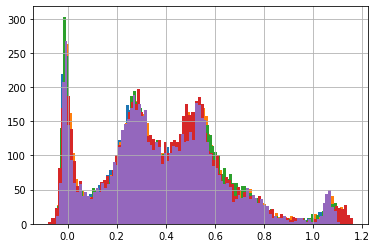

In [26]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'/oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()